In [1]:
from tensorflow.keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

The train data has 404 samples with 13 features, while the test data has 102 samples with, ofcourse 13 features too. features include per capita crime rate, average number of rooms per dwelling, accessibiliity to highway e.t.c.

In [4]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

Above is a slice of the train targets. the train targets are the median values of home-ownership homes, in thousands of dollars. so the firsts above is $15200 dollars and so on.

Remember the above data is from the mid 1970s.

## Preparing our data
The data take wildly different ranges. each feature in the data has a different scale. So while its possible for our model to adapt and learn from such heterogenous data, it will make learning more difficult.

We will do a feature-wise normalization: that is subtracting the mean from each feature and deviding it by the STDV., so the feature is centrered around 0 with a unit STDV..

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean                     # same as train_data = train_data - mean, but in a more pythonic way.
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

NOTE: The mean and std used for normalizing the test data is computed from the train data. No quantity computed for test data should be used in workflow. Remember test data is for testing our model. This is very IMPORTANT !

## Building our model
we have a small data for this project, so we will use a small model. Generally, the less the training data, the worse the overifitting will be, and one way to mitigate this is by using a small model.

We will need to instantiate the model many times, so we will use a function to construct it.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])   # mae - mean absolute error for evaluating the perfomance of reg. model.
    return model


We are using the Mean Squared Error loss function for this model.
we are also monitoring a metric Mean Absolute error: Since it's an absolute value, a loss of 0.5 or -0.5 will mean the model's prediction is off by 500 dollars.

## Validating our approch using the k-fold validation
To evaluate our model while we keep adjusting its parameters, we could split the data into training set and validation set.
Here, we have a few data points, i.e. the validation set would end up being very small too. This will might cause high variance with regards to the validation split.

The best practice in such situations is the use of k-fold cross-validation. that is splitting the data into k partitions,instantiating k identical models and training training each one into k-1 partitions while evaluating on the remaining  partitions. the validation score of the model will then be the average of the k validation scores.

In [11]:
import numpy as np

In [12]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print(f"processing fold #{i}")
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=1, verbose=0)     #verbose=0 means we are training the model in a silent mode

  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)


processing fold #0
processing fold #1
processing fold #2
processing fold #3


Now lets check our results.

In [13]:
all_scores

[2.1702070236206055, 2.888437032699585, 2.5707201957702637, 2.329188823699951]

In [15]:
np.mean(all_scores)

np.float64(2.4896382689476013)

we ofcourse have different validation scores, from 2.17 to 2.88. the mean is 2.5 which is much more reliable score than any single score. however, we are off by $2500 on average, which is alot considering the prices ranges from 10,000 to 50,000 dollars.

lets train the model a bit longer, and modifying the training loop by saving the the per-epoch val score for each fold.

In [16]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print(f"processing fold #{i}")
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs, batch_size=16, verbose=0)     #verbose=0 means we are training the model in a silent mode

  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


In [18]:
len(mae_history)

500

So for every epoch, the validation score, which is the Mean Absolute Error in our case, is saved. we can now compute the average for the MAE score per epoch for all folds.

In [21]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [23]:
len(average_mae_history)

500

Lets plot the epoch vs the validation score to inspect the behaviour.

In [24]:
import matplotlib.pyplot as plt

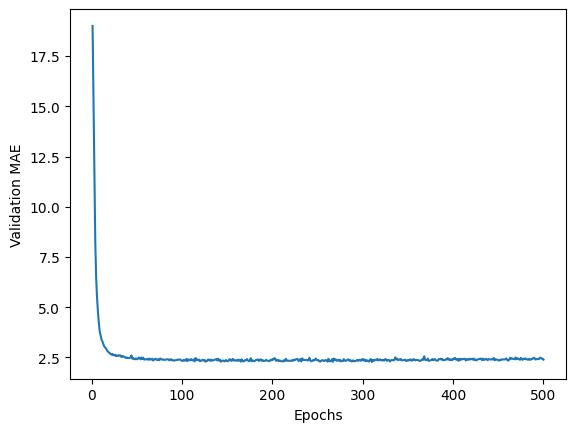

In [25]:
plt.plot(range(1,len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs") ; plt.ylabel("Validation MAE")
plt.show()

It is difficult to read the plot due to scaling issue. the val MAE score of the first few points is dramatically higher than the values that follow. the book suggests we omit the first 10 data points.i will omit the first 20 and see the result

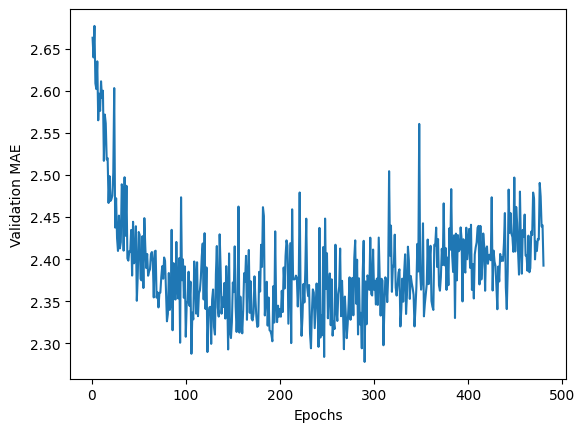

In [26]:
truncated_mae_history = average_mae_history[20:]
plt.plot(range(1,len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs") ; plt.ylabel("Validation MAE")
plt.show()

the plot does not quite show much of the validation MAE. it did not capture somw important data point.

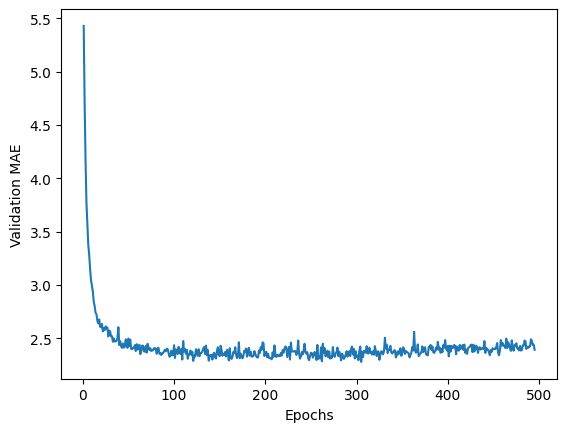

In [27]:
truncated_mae_history = average_mae_history[5:]
plt.plot(range(1,len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs") ; plt.ylabel("Validation MAE")
plt.show()

here, the scaling has not much improved, so we will go with the books and omit the first 10

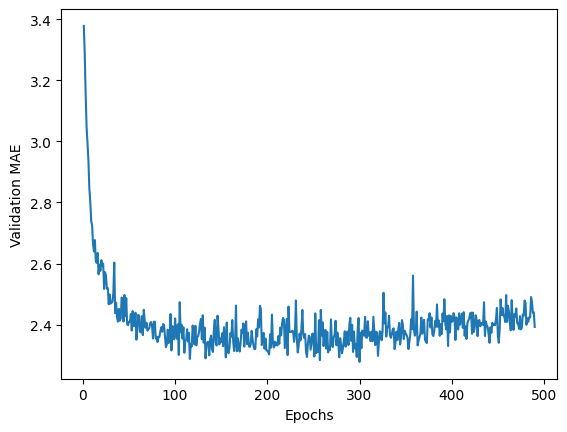

In [28]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1,len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs") ; plt.ylabel("Validation MAE")
plt.show()

We can see that the validation MAE stops improving (reducing) significantly  after 120-140 epochs (this is including the 10 epochs). so past this point, we start overfitting. we will now train the model again with this information.